In [2]:
include("includes.jl");

### Setup

In [3]:
@everywhere measurements, measurements_mask = load_experiments()
@everywhere n_measurements = size(measurements)[1]
@everywhere max_intersects = size(measurements)[2]

@everywhere prior = Uniform(8,11)

@everywhere Θ₀ = [5*pi/180, 0]
@everywhere function dΘ(g)
    Θ -> [Θ[2], -g*sin(Θ[1])/8]
end

@everywhere loglikelihood = (k, n, g) ->
    let
        Gg = rk4s(dΘ(g), Θ₀, [0; measurements[k,1:n][measurements_mask[k,1:n] .!= 0]], 0.01) 
        b = log.(abs.(0.01 ./ (0.01 + Gg[2:end,1]))).^2
        sum(b)/0.5
    end;

### Plotting the likelihood

In [ ]:
fig = figure()
evaluation_mesh=collect(0:0.01:30)
mesh = linspace(8,10,100)

@manipulate for n = 1:max_intersects, kid=1:n_measurements
    
    lhood = -(g -> loglikelihood(kid,n,g)).(mesh)
    elhood = exp.(lhood)
    elhood = elhood / sum(elhood)
    
    mle = mesh[findmax(lhood)[2]]
    
    Gg_ref = rk4s(dΘ(9.8), Θ₀, evaluation_mesh, 0.01)[:,1]
    Gg_mle = rk4s(dΘ(mle), Θ₀, evaluation_mesh, 0.01)[:,1]
    
    withfig(fig) do
        subplot(2,2,1)
        scatter(mesh, lhood,s=1)
        subplot(2,2,2)
        scatter(mesh, elhood,s=1)
        subplot(2,1,2)
       
        plot(evaluation_mesh,Gg_mle,c="red",linewidth=1)
        plot(evaluation_mesh,Gg_ref,c="black",linestyle="--", linewidth=1)
        
        mm = measurements[kid,1:n][measurements_mask[kid,1:n] .!= 0]
        scatter(mm, zeros(mm), c="green",marker="o",alpha=0.1) 
    end
end

### Metropolis Hastings with gaussian noise

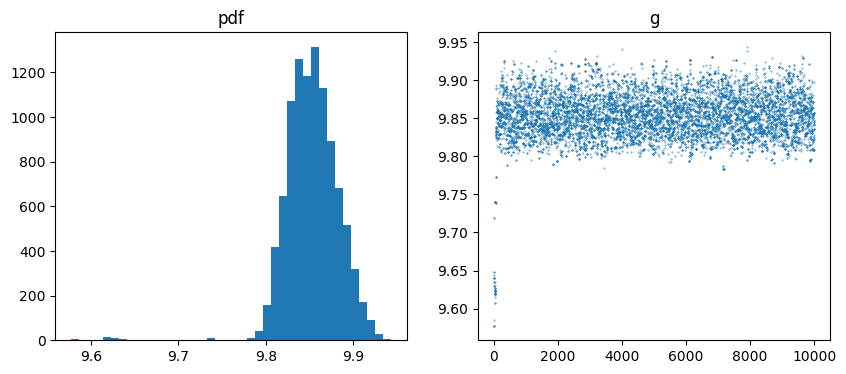

5300 / 10000 of the sampled particles were accepted (53.0%)
        
The expectation estimation is of 9.853620263192825


In [5]:
function GaussianMetropolisHastings(K, prior, ϕ, γ)
    x₀ = rand(prior, 1)
    
    X = zeros(K, length(x₀))
    Y = zeros(K, length(x₀))
    W = zeros(K)
    accepted = 0
    
    w = MvNormal(γ^2*eye(length(x₀)))
    x = x₀
    ϕₓ = ϕ(x)
    
    for k=1:K
        y = x + rand(w)
        ϕₙ = ϕ(y)
        if rand() < min(1, (pdf(prior, y[1])/pdf(prior, x[1]))*exp(ϕₓ-ϕₙ))
            x = y
            ϕₓ = ϕₙ
            accepted += 1
        end
        
        W[k] = ϕₙ
        Y[k,:] = y
        X[k,:] = x
    end
    X, Y, exp.(-W), accepted
end

srand(42)
out = GaussianMetropolisHastings(10000, prior, g -> loglikelihood(1, 11, g[1]), 0.05)
plotMCMC(out)

### Sequential Monte Carlo

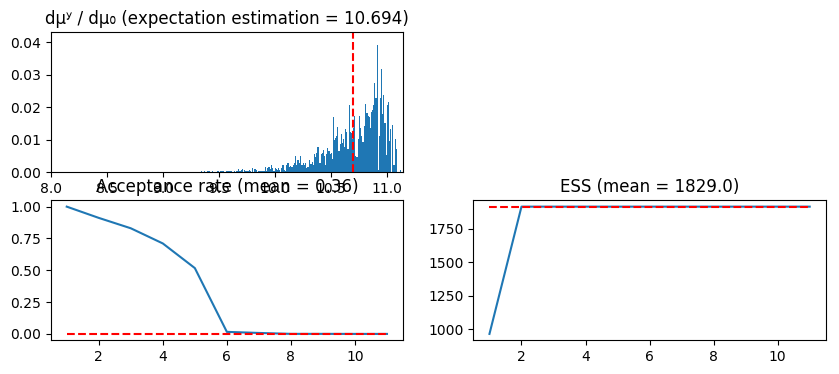

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f4658eaaa50>

In [6]:
function SequentialMonteCarlo(X₀, p, lhood; μ=0.1)
    # initialization
    N,d = size(X₀)
    w = MvNormal(μ^2 * eye(d))

    X = SharedArray{Float64}(X₀)
    dX = zeros(X₀)
    
    W = ones(N)/N
    Wₙ = SharedArray{Float64}(N)
    
    acceptance_rate = ones(p) ./ N
    ess = zeros(p)
    
    S = 1
    
    # initialize
    @sync @parallel for i=1:N
        Wₙ[i] = lhood(1, X[i,:])
    end
    
    Z = vecdot(W, Wₙ)
    W = W.*Wₙ / vecdot(W, Wₙ)

    for n = 1:p
        # update
        dX = rand(w, N)'
        acceptance_rate[n] *= @sync @parallel (+) for i=1:N
            xₙ = X[i,:] + dX[i,:]
            wₙ = lhood(n, xₙ)

            accepted = 0
            if rand() < min(1, wₙ / W[i])
                Wₙ[i] = Wₙ[i]*wₙ
                X[i,:] = xₙ
                accepted = 1
            end
            accepted
        end
        # normalize weights
        W = Wₙ / sum(Wₙ)

        # resample
        ess[n] = 1 / vecdot(W,W)
        if ess[n] < N/2            
            perm = rand(Categorical(W), N)
            X = X[perm, :]
            Wₙ = Wₙ[perm]
            W = ones(N)/N
        end
    end
    
    W,X,acceptance_rate,ess
end

srand(42)

N = 2500
X₀ = reshape(rand(prior, N), N, 1)

outs = SequentialMonteCarlo(X₀, 11, (n, g) -> exp(-loglikelihood(1, n, g[1])), μ=0.05)
plotSMC(outs)